# Notebook Imports

In [1]:
#pip install bs4
#pip install wordcloud

In [2]:
import sys
print(sys.executable)

C:\Users\Amine\Desktop\ml-course\Spam_Filter_Project\env\python.exe


In [3]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer  # We can choose another one example: SnowballStemmer() 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

from collections import Counter
%matplotlib inline

# Constants

In [4]:
EXEMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

HAM_CAT = 0
SPAM_CAT = 1
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email_text_data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/03_Testing/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
BOLD_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
LIGHT_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'

# Reading Files

In [5]:
stream  = open(EXEMPLE_FILE,encoding='latin-1')
message = stream.read()
stream.close()
print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [6]:
import sys 
sys.getfilesystemencoding()

'utf-8'

In [7]:
stream  = open(EXEMPLE_FILE,encoding='latin-1')
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email body extraction

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            stream  = open(filepath,encoding='latin-1')
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

# Puting data into pandas DataFrames

In [9]:
def df_from_directory(path, classification):
    rows = []
    rows_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({"CATEGORY": classification, "MESSAGE": email_body})
        rows_names.append(file_name)
    return pd.DataFrame(rows, index=rows_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
#spam_emails.head()
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [11]:
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print(f'Shape of the entire datadframe is: {data.shape}')
data.head()

Shape of the entire datadframe is: (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [13]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


# Data Cleaning: Checking for Missing Values

In [14]:
# Check if any message bodies are null
data.MESSAGE.isnull().values.any()

False

In [15]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [16]:
(data.MESSAGE.str.len() == 0).sum()

3

### Locate emplty emails

In [17]:
data[data.MESSAGE.str.len() == 0]

,CATEGORY,MESSAGE
cmds,1,
cmds,1,
cmds,0,


# Remove System File Entries from Dataframe

In [18]:
data.drop(['cmds'], axis=0, inplace=True)

In [19]:
data[data.MESSAGE.str.len() == 0]

,CATEGORY,MESSAGE


In [20]:
data.shape

(5796, 2)

# Add Document Ids to track Emails in Dataset

In [21]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids
data.head()

,CATEGORY,MESSAGE,DOC_ID
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,2
00004.eac8de8d759b7e74154f142194282724,1,##############################################...,3
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...,4


In [22]:
data['FILE_NAME'] = data.index
data.tail()
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


# Save to file using Pandas

In [23]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [24]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [25]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

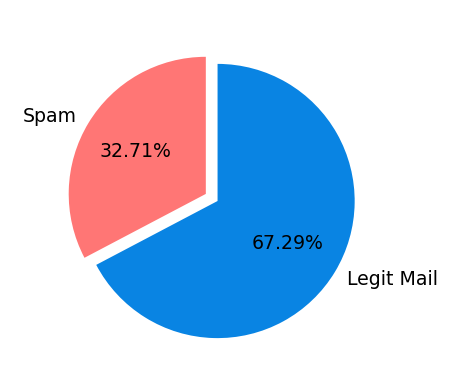

In [26]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#0984e3']
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.2f%%', colors = custom_colours, explode=[0, 0.1])
plt.show()

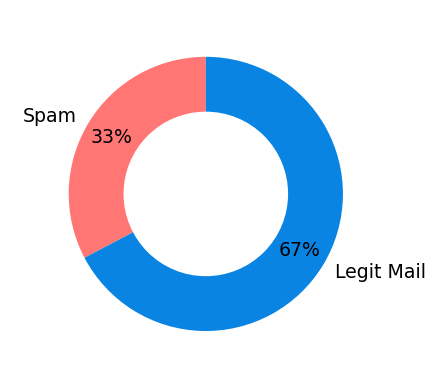

In [27]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#0984e3']
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.0f%%', colors = custom_colours, pctdistance = 0.8)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)
plt.show()

# Natural Language Processing 

## Text Pre-Processing

### Download the NLTK Ressources (Tokenizer & Stopwords)

In [28]:
#nltk.download('punkt')
#nltk.download("stopwords")

In [29]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

## Removing Stop Words

In [30]:
stop_words = set(stopwords.words('english'))

In [31]:
if 'hello' not in stop_words: print("Found it!")

Found it!


In [32]:
msg = "All Hello everyone, how are you? We are fine thank you!!"
words = word_tokenize(msg.lower())
filtred_words = []
for word in words:
    if word in stop_words:
        filtred_words.append(word)
print(filtred_words)

['all', 'how', 'are', 'you', 'we', 'are', 'you']


## Word Stems and Stemming

In [33]:
msg = "All Hello everyone, how are you? We are fine thank you!! that makes me feel good"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtred_words = []
#Append non-stop words to filtered-words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtred_words.append(stemmed_word)
print(filtred_words)

['hello', 'everyon', ',', '?', 'fine', 'thank', '!', '!', 'make', 'feel', 'good']


## Removing Punctuation

In [34]:
msg = "All Hello everyone, how are you? We are fine thank you!! that makes me feel good"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtred_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtred_words.append(stemmed_word)
print(filtred_words)

['hello', 'everyon', 'fine', 'thank', 'make', 'feel', 'good']


## Removing HTML tags from Emails

In [35]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], "html.parser")
print(soup.prettify())


<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=

 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=

/TR&gt;
  <!-- End Calypso -->
  <font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
   <center>
    Save up to 70% o

In [36]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## Email Processing

In [37]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                      stop_words = set(stopwords.words('english'))):
    # Remove HTML tags
    soup = BeautifulSoup(message, "html.parser")
    cleaned_text = soup.get_text()
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtred_words = []
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtred_words.append(stemmed_word)
    return filtred_words

In [38]:
clean_msg_no_html(data.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Apply Cleaning and Tokenisation to all messages

### Slicing DataFrames and Series & Creating Subsets

In [42]:
#first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_msg_no_html)

In [43]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

192

In [44]:
%%time
# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\Amine\Desktop\ml-course\Spam_Filter_Project\env\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 59.2 s


In [45]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [46]:
data[data.CATEGORY == 1].head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [47]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [48]:
doc_ids_spam

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
           dtype='int64', name='DOC_ID', length=1896)

### Subsetting a Series with an Index

In [49]:
type(doc_ids_spam)

pandas.core.indexes.numeric.Int64Index

In [50]:
type(nested_list)

pandas.core.series.Series

In [51]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape

(3900,)

In [52]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.shape

(1896,)

In [53]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [54]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [55]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13242

In [56]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating a Word Cloud

# Word Cloud of Ham and Spam Messages

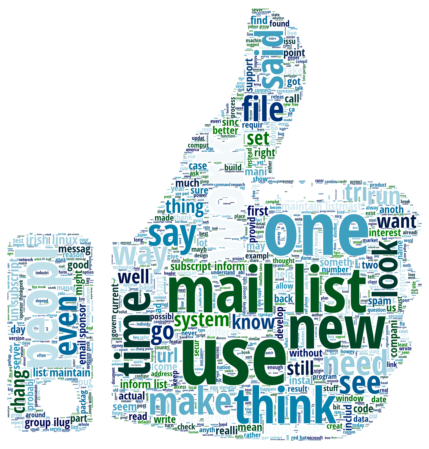

In [66]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask) # Converts the image object to an array

# Genrate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                       max_words=2000, colormap='ocean', font_path=BOLD_FONT_FILE)
word_cloud.generate(ham_str)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

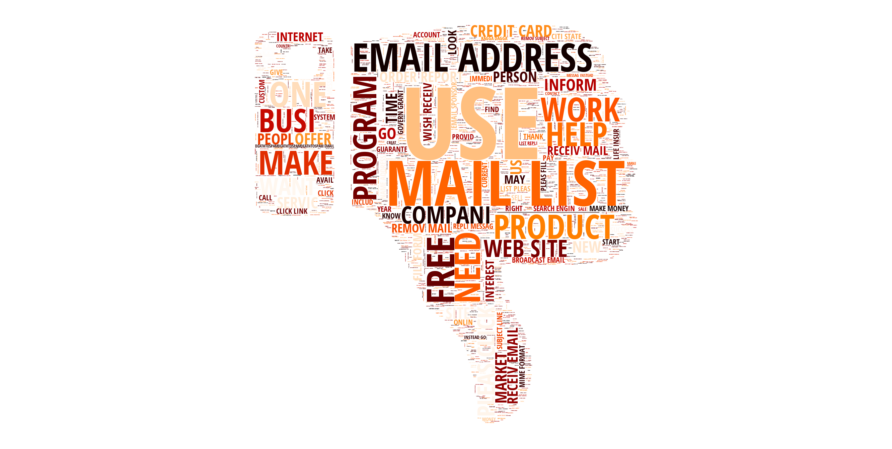

In [67]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask) # Converts the image object to an array

# Genrate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                       max_words=2000, colormap='gist_heat', font_path=BOLD_FONT_FILE)
word_cloud.generate(spam_str.upper())
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [68]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]


C:\Users\Amine\Desktop\ml-course\Spam_Filter_Project\env\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [69]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Number of unique words: ", unique_words.shape[0])

Number of unique words:  27334


In [70]:
frequent_words = unique_words[:VOCAB_SIZE]
print("Most common words:\n", frequent_words[:10])

Most common words:
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [71]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [72]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [73]:
#any(vocab.VOCAB_WORD == 'machine') # inefficient 
'else' in set(vocab.VOCAB_WORD)

False

In [74]:
emails_content = pd.Series(nested_list)
emails_content

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [75]:
def longest_email(content = emails_content):
    max_val = 0
    longestEmail = []
    index = 0
    for i in range(0, len(emails_content)):
        if len(content[i]) > max_val:
            max_val = len(content[i])
            numberOfWords = max_val
            longestEmail = content[i]
            index = i
    return numberOfWords, longestEmail, index
numberOfWords, longestEmail, index = longest_email(emails_content)

In [76]:
numberOfWords

7671

In [77]:
index

5775

In [78]:
len(emails_content[index])

7671

In [79]:
clean_email_lenghts = [len(sublist) for sublist in stemmed_nested_list]
np.max(clean_email_lenghts)


7671

In [80]:
np.argmax(clean_email_lenghts)

5775

In [81]:
len(emails_content[5401])

193

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column 

In [82]:
type(stemmed_nested_list)

pandas.core.series.Series

In [83]:
# Convert Series object to list and then convert list to DataFrame
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [84]:
word_columns_df.shape

(5796, 7671)

### Spliting the data into Training and Testing Dataset

In [85]:
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [86]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                    random_state = 42, test_size = 0.3)

In [87]:
X_test.shape[0]

1739

In [88]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [89]:
type(y_train)

pandas.core.series.Series

### Create a Sparse Matrix for the Training data

In [90]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index[4]

'get'

In [91]:
word_index.get_loc('thu')

392

In [92]:
X_train[0][0]

'save'

In [93]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordred by word id
    labels: category as a series (y_train, y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {
                    'LABEL': category, 'DOC_ID': doc_id,
                    'OCCURENCE': 1, 'WORD_ID': word_id
                }
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [94]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 14min 21s


In [95]:
sparse_train_df.shape

(429253, 4)

### Combine Occurrences with the Pandas groupby() Method

In [96]:
train_grouped = sparse_train_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [97]:
vocab.at[2, "VOCAB_WORD"]

'list'

In [98]:
data.MESSAGE[2]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [99]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [100]:
train_grouped.shape

(258376, 4)

### Save training Data as .txt File

In [101]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [102]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 16min 4s


In [103]:
sparse_test_df.shape

(203370, 4)

In [104]:
test_grouped = sparse_test_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      2       1              1
       3       1              4
       4       1              2
       5       1              1
       6       1              2

In [105]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [106]:
test_grouped.shape

(117781, 4)

### Save test Data as .txt file

In [107]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt="%d")

In [108]:
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [109]:
train_grouped = pd.read_csv(TRAINING_DATA_FILE, sep=" ", header=None)
train_grouped.columns = ["DOC_ID", "WORD_ID", "LABEL", "OCCURENCE"]
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [110]:
test_grouped = pd.read_csv(TEST_DATA_FILE, sep=" ", header=None)
test_grouped.columns = ["DOC_ID", "WORD_ID", "LABEL", "OCCURENCE"]
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [111]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [112]:
len(train_doc_ids),X_train.shape[0], len(test_doc_ids),X_test.shape[0]

(4013, 4057, 1724, 1739)

In [113]:
set(X_train.index.values) - train_doc_ids

{22,
 38,
 73,
 77,
 86,
 91,
 94,
 114,
 127,
 138,
 186,
 193,
 197,
 205,
 206,
 302,
 328,
 335,
 338,
 369,
 402,
 545,
 546,
 766,
 875,
 878,
 924,
 929,
 939,
 940,
 965,
 983,
 988,
 1035,
 1100,
 1164,
 1170,
 1234,
 1248,
 1313,
 1360,
 1686,
 1846,
 1878}

In [114]:
data.MESSAGE[939]

'------=_NextPart_000_00D1_42B32C7D.B8655D52\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\nSWYgeW91ciBob21lIGlzIHNlcnZlZCBieSBhIHNlcHRpYyBzeXN0ZW0sIHlv\n\ndSB3aWxsIGJlIGFibGUgdG8gcmVjZWl2ZQ0KaW52YWx1YWJsZSBpbmZvcm1h\n\ndGlvbiBvbiBob3cgdG8gZWxpbWluYXRlIHB1bXAgb3V0cywgbWFpbnRhaW4g\n\ndGhlDQpzeXN0ZW0gcHJvcGVybHkgYW5kIGN1cmUgcHJvYmxlbXMgc3VjaCBh\n\ncyBiYWNrdXBzLCB3ZXQgc3BvdHMsIG9kb3IsIGV0Yy4NCg0KWW91IGNhbiBk\n\nbyB0aGlzIGJ5IGNoZWNraW5nIG91dCBvdXIgU1BDIHByb2dyYW0gYXQ6DQoN\n\nCmh0dHA6Ly93d3cuYmxhY2tzbm93Y2xvdWQuY29tDQoNCkluIGFkZGl0aW9u\n\nLCB5b3Ugd2lsbCBoYXZlIHRoZSBvcHBvcnR1bml0eSB0byBwYXJ0aWNpcGF0\n\nZSBpbiBhIGZyZWUNCnRyaWFsIHRvIHRlc3QgdGhlIGVmZmVjdGl2ZW5lc3Mg\n\nb2YgU1BDLg0KDQpQbGVhc2UgY2hlY2sgdXMgb3V0Lg0KDQpUaGFuayB5b3Uu\n\nDQoNClNpbmNlcmVseSwNCg0KU1BDDQoNClAuUy4gUmVtZW1iZXIsIHlvdSBt\n\ndXN0IGNsaWNrIG9uIHRoaXMgbGluayB0byByZWNlaXZlIHRoaXMgaGVscGZ1\n\nbA0KaW5mb3JtYXRpb24hDQoNCmh0dHA6Ly93d3cuYmxhY2tzbm93Y2xvdWQu\n\nY29tDQoNCg0KDQpUbyBiZSByZW1vd